In [1]:
using Pkg; Pkg.activate("/Users/deszoeks/Projects/ASTRAL/lidar")

using Revise
using Dates
using PyPlot

# using CSV
# using DataFrames
# using DelimitedFiles
# using Printf

  Activating project at `~/Projects/ASTRAL/lidar`


In [2]:
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x

m2n (generic function with 1 method)

In [3]:
# functions for reading hpl files

"count the headlines before a line that starts with ****"
function numheaderlines(file)
    n = 0 
    open(file) do f
        while !startswith( readline(f), "****" )
            n += 1
        end
    end
    return n + 1
end

"""
header = read_streamlinexr_head(file_path)
Read the Halo Photonics StreamLineXR .hpl file header.
"""
function read_streamlinexr_head(file_path)
    # put the header in a Dict
    h = Dict(
        :nlines => countlines(file_path),
        :nheaderlines => 
        # variables defined outside the do block, defaults will be overwritten.
        :ngates => Int32(104),
        :gatelength => 30.0,
        :nrays => Int32(1), # or 40
        :start_time => DateTime(2024,5,2,10,0,0),
        :vel_resolution => 0.0380,
        :headr1 => split("time Azimuth Elevation Pitch Roll"),
        :units1 => split("hours degrees degrees degrees degrees"),
        :headr2 => ["Range Gate", "Doppler", "Intensity", "Beta"],
        :units2 => ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
    )

    # open and read the file header, updating the header dict a
    open(file_path) do file
        for _ in 1:2 # skip lines
            readline(file)
        end

        # read number of gates from line 3
        h[:ngates] = parse(Int32, last(split(readline(file)))) # 104
        # read gate length from line 4
        h[:gatelength] = parse(Float64, last(split(readline(file))))
        for _ in 5:6 # skip
            readline(file)
        end

        # read number of rays from line 7
        h[:nrays] = parse(Int32, last(split(readline(file)))) # 1 for Stare or 40 for User
        for _ in 8:9 # skip
            readline(file)
        end

        # read start time from line 10
        tl = split(readline(file))
        h[:start_time] = DateTime(tl[end-1]*tl[end], "yyyymmddHH:MM:SS.ss")
        # read velocity resolution (m/s) line 11
        h[:vel_resolution] = parse(Float64, last(split(readline(file))))
        readline(file) # skip line 12
        # read header 1 from line 13
        hdrln = split(readline(file))[5:end]
        h[:headr1] = hdrln[1:2:end]
        h[:units1] = hdrln[2:2:end]
        readline(file) # skip line 14
        # read header 2 from line 15
        hdrln = split(readline(file))[4:end] # but don't parse it
        h[:headr2] = ["Range Gate", "Doppler", "Intensity", "Beta"]
        h[:units2] = ["none", "(m/s)", "(SNR + 1)", "(m-1 sr-1)"]
        # for _ in 16:17 # skip
        #     readline(file)
        # end
    end

    return h
end

"""
modifying read_streamlinexr_data!(file_path, header, beams)
Read data and fill in the beams.
"""
function read_streamlinexr_stare!(file_path, h, beams, nheaderlines=17)
    # use header information in h
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-nheaderlines) / (1+ngates)) # = nrays*ntimes
    beam_timeangles = zeros(nbeams, 5)
    beam_velrad = zeros(nbeams, ngates, 4)

    # for User wind profiles beam <--> VAD ray
    # for Stare beam <--> time

    # open and read the file
    open(file_path) do file
        for _ in 1:nheaderlines # skip header lines
            readline(file)
        end

        # now read data
        for ibeam = 1:nbeams
            # beam described by a batch of 1+ngates lines
            # Read the beam parameter line
            line = readline(file)
            beam_timeangles[ibeam,:] .= parse.(Float64, split(line))
            # Read each gate in the beam
            for igate = 1:ngates
                line = readline(file)
                beam_velrad[ibeam, igate,:] .= parse.(Float64, split(line))
            end
        end
    end # close the file

    # parse the variables into the dict beams
    # by beam
    beams[:time     ] .= beam_timeangles[:,1] # decimal hours
    beams[:azimuth  ] .= beam_timeangles[:,2] # degrees
    beams[:elevangle] .= beam_timeangles[:,3] # degrees
    beams[:pitch    ] .= beam_timeangles[:,4]
    beams[:roll     ] .= beam_timeangles[:,5]
    # by gate
    beams[:height   ] .= (beam_velrad[1,:,1].+0.5) .* h[:gatelength] # center of gate, assumes same for all beams

    # dependent variables (beam, gate)
    beams[:dopplervel] .= beam_velrad[:,:,2] # m/s
    beams[:intensity ] .= beam_velrad[:,:,3] # SNR + 1
    beams[:beta      ] .= beam_velrad[:,:,4] # m-1 sr-1  backscatter?
end

"""
beams, h = read_streamlinexr(file_path)
Read the Photonics StreamLineXR .hpl file data and header.
"""
function read_streamlinexr_stare(file_path, nheaderlines=17)
    # use header information in h
    h = read_streamlinexr_head(file_path)
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeams = round(Int, (nlines-17) / (1+ngates)) # = nrays*ntimes
    # initialize a beams Dict
    beams = Dict(
        :time      => Vector{Union{Float32,Missing}}(missing, nbeams), # decimal hours
        :azimuth   => Vector{Union{Float32,Missing}}(missing, nbeams), # degrees
        :elevangle => Vector{Union{Float32,Missing}}(missing, nbeams),
        :pitch     => Vector{Union{Float32,Missing}}(missing, nbeams),
        :roll      => Vector{Union{Float32,Missing}}(missing, nbeams),

        :height    => Vector{Union{Float32,Missing}}(missing, ngates), # center of gate

        # dependent variables (beam, gate)
        :dopplervel => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # m/s
        :intensity  => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates), # SNR + 1
        :beta       => Matrix{Union{Float32,Missing}}(missing, nbeams,ngates) # m-1 sr-1  backscatter?
        )

    # read file and fill beams with data
    read_streamlinexr_stare!(file_path, h, beams, nheaderlines)
    return beams, h
end

read_streamlinexr_stare

In [4]:
"plot_stare(beams) plots StreamlineXR lidar backscatter and Doppler velocity."
function plot_stare(beams)
    subplot(2,1,1)
    pcolormesh(beams[:time][:], beams[:height][3:end]/1e3, pd(beams[:beta][:,3:end]),
        cmap=ColorMap("RdYlBu_r"))
    ylim([0, 2])
    colorbar()

    X = beams[:dopplervel]
    X[beams[:intensity] .<= 1.02] .= NaN
    subplot(2,1,2)
    pcolormesh(beams[:time][:], beams[:height][4:end]/1e3, pd(X[:,4:end]),
        cmap=ColorMap("RdYlBu_r"), vmin=-3, vmax=3)
    ylim([0, 2])
    colorbar()
    
    tight_layout()
    return gcf()
end

plot_stare

In [10]:
lidardir = "./data/lidar"
datestamp = "20240508"
datafile = joinpath(lidardir, datestamp, "Stare_116_$(datestamp)_06.hpl")

beams, head = read_streamlinexr_stare(datafile)
beams

Dict{Symbol, Array{Union{Missing, Float32}}} with 9 entries:
  :time       => [6.00528, 6.00556, 6.00585, 6.00613, 6.00641, 6.0067, 6.00698,…
  :dopplervel => [0.0382 -0.1147 … 7.7205 -16.7405; 0.0 -0.1529 … -0.8791 -17.7…
  :roll       => [-1.42, -3.15, -0.4, -1.21, -0.4, -2.54, -0.19, -1.83, 0.21, -…
  :beta       => [1.44775f-7 2.63448f-7 … 2.44864f-6 7.37624f-7; 4.07403f-7 5.5…
  :elevangle  => [90.02, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0  …
  :azimuth    => [359.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  :height     => [12.0, 36.0, 60.0, 84.0, 108.0, 132.0, 156.0, 180.0, 204.0, 22…
  :intensity  => [1.00257 1.00467 … 1.00664 1.00198; 1.00724 1.00977 … 1.00989 …
  :pitch      => [0.11, 0.21, 0.62, -0.4, -0.51, 0.11, 0.41, -0.61, -0.2, 0.0  …

Stare_116_20240428_00.png, Stare_116_20240428_01.png, Stare_116_20240428_02.png, Stare_116_20240428_03.png, Stare_116_20240428_04.png, Stare_116_20240428_05.png, Stare_116_20240428_06.png, Stare_116_20240428_07.png, Stare_116_20240428_08.png, Stare_116_20240428_09.png, Stare_116_20240428_10.png, Stare_116_20240428_11.png, Stare_116_20240428_12.png, Stare_116_20240428_13.png, Stare_116_20240428_14.png, Stare_116_20240428_15.png, Stare_116_20240428_16.png, Stare_116_20240428_17.png, Stare_116_20240428_18.png, Stare_116_20240428_19.png, Stare_116_20240428_20.png, Stare_116_20240428_21.png, Stare_116_20240428_22.png, Stare_116_20240428_23.png, 
Stare_116_20240429_00.png, Stare_116_20240429_01.png, Stare_116_20240429_02.png, Stare_116_20240429_03.png, Stare_116_20240429_04.png, Stare_116_20240429_05.png, Stare_116_20240429_06.png, Stare_116_20240429_07.png, Stare_116_20240429_08.png, Stare_116_20240429_09.png, Stare_116_20240429_10.png, Stare_116_20240429_11.png, Stare_116_20240429_12.png, 

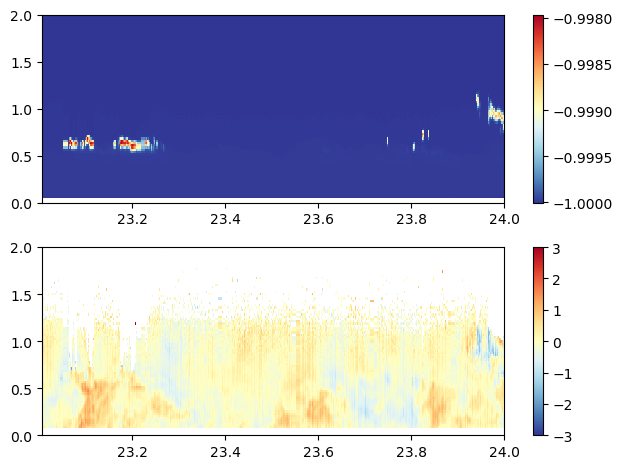

In [12]:
# plot it
for datestamp in filter(startswith("2024"), readdir(lidardir))
    for starefile in filter(startswith("Stare"), readdir(joinpath(lidardir,datestamp)))
        beams, head = read_streamlinexr_stare(joinpath(lidardir,datestamp,starefile))
        clf()
        plot_stare(beams)
        fileout = starefile[1:end-4]*".png"
        savefig(joinpath(lidardir,"plot",fileout))
        print(fileout*", ")
    end
    print("\n")
end

In [ ]:
# coherent filtering

using FFTW
using Plots

function remove_coherent_component(signal1::Vector{Float64}, signal2::Vector{Float64})
    # Fourier Transform of the signals
    S1 = fft(signal1)
    S2 = fft(signal2)
    
    # Compute cross-spectral density
    P12 = S1 .* conj(S2)
    # P21 = conj(P12)
    
    # Compute auto-spectral density
    P11 = S1 .* conj(S1)
    P22 = S2 .* conj(S2)
    
    # Compute coherence
    coherence = abs.(P12).^2 ./ (P11 .* P22)
    
    # Compute the coherent part
    coherent_part_S1 = coherence .* S2
    coherent_part_S2 = coherence .* S1
    
    # Remove the coherent part
    clean_S1 = S1 .- coherent_part_S1
    clean_S2 = S2 .- coherent_part_S2
    
    # Inverse Fourier Transform to get the time-domain signals
    clean_signal1 = real(ifft(clean_S1))
    clean_signal2 = real(ifft(clean_S2))
    
    return clean_signal1, clean_signal2
end

# Example usage
fs = 1000  # Sampling frequency
t = 0:1/fs:1-1/fs  # Time array
signal1 = sin.(2 * π * 50 * t) .+ 0.5 .* randn(length(t))  # Signal 1 with noise
signal2 = sin.(2 * π * 50 * t) .+ 0.5 .* randn(length(t))  # Signal 2 with noise

clean_signal1, clean_signal2 = remove_coherent_component(signal1, signal2)

# Plot the results
plot(t, signal1, label="Original Signal 1")
plot!(t, clean_signal1, label="Cleaned Signal 1", linestyle=:dash)

plot(t, signal2, label="Original Signal 2")
plot!(t, clean_signal2, label="Cleaned Signal 2", linestyle=:dash)
